# Part 1


In [ ]:
# Import neccesary packages
import os, time, warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", context="notebook")

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.metrics import (confusion_matrix, accuracy_score, precision_score,
                             recall_score, f1_score, classification_report)

# Load dataset
data = "https://github.com/ArinB/MSBA-CA-03-Decision-Trees/blob/master/census_data.csv?raw=true"
df = pd.read_csv(data)

df.head(3)

,hours_per_week_bin,occupation_bin,msr_bin,capital_gl_bin,race_sex_bin,education_num_bin,education_bin,workclass_bin,age_bin,flag,y
0,b. 31-40,b. Mid - Low,b. Mid,c. > 0,c. High,c. 13,c. Bachelors,b. income,d. 36-40 & 56-60,train,0
1,a. 0-30,e. High,c. High,a. = 0,c. High,c. 13,c. Bachelors,b. income,e. 40-55,train,0
2,b. 31-40,a. Low,b. Mid,a. = 0,c. High,b. 9-12,b. Mid,b. income,d. 36-40 & 56-60,train,0


In [ ]:
obj_cols = df.select_dtypes(include=["object"]).columns.tolist()
for c in obj_cols:
    print(f"\n--- {c} (top 10) ---")
    display(df[c].value_counts(dropna=False).head(10))

# Strip whitespace/uniform text for object columns
for c in obj_cols:
    df[c] = df[c].astype(str).str.strip()

# Guess target and split columns based on common names/patterns used in the assignment
possible_targets = ["income", "Income", "target", "Target", "class", "Class", "income_category", "y"]
possible_splits  = ["split", "Split", "DataSplit", "data_split", "train_test", "TrainTest", "set"]

target_col = next((c for c in possible_targets if c in df.columns), None)
split_col  = next((c for c in possible_splits  if c in df.columns), None)

def find_split_column(d):
    for c in d.columns:
        vals = set(str(v).lower() for v in d[c].dropna().unique())
        if {"train","training"} & vals and {"test","testing"} & vals:
            return c
    return None

if split_col is None:
    split_col = find_split_column(df)

print("Guessed target column:", target_col)
print("Guessed split column:", split_col)

assert target_col is not None, "Please set target_col to the correct target column from your dataset."
assert split_col  is not None, "Please set split_col to the correct train/test column from your dataset."

# Normalize target to 0/1 labels if the file uses <=50K, >50K strings (per brief)
def map_target(y):
    y = y.astype(str).str.strip()
    return y.map({">50K": 1, "<=50K": 0, "1": 1, "0": 0}).astype(int)

df[target_col] = map_target(df[target_col])

df.head(3)


--- hours_per_week_bin (top 10) ---


,count
hours_per_week_bin,
b. 31-40,26639
d. 41-50 & 61-70,9819
a. 0-30,7851
e. 51-60,3759
c. 71-100,774



--- occupation_bin (top 10) ---


,count
occupation_bin,
c. Mid - Mid,13971
b. Mid - Low,12947
e. High,12258
a. Low,7237
d. Mid - High,2429



--- msr_bin (top 10) ---


,count
msr_bin,
c. High,22047
b. Mid,15868
a. Low,10927



--- capital_gl_bin (top 10) ---


,count
capital_gl_bin,
a. = 0,42525
c. > 0,4035
b. < 0,2282



--- race_sex_bin (top 10) ---


,count
race_sex_bin,
c. High,29737
b. Mid,16457
a. Low,2648



--- education_num_bin (top 10) ---


,count
education_num_bin,
b. 9-12,30324
c. 13,8025
a. 0-8,6408
d. 14,2657
e. 15+,1428



--- education_bin (top 10) ---


,count
education_bin,
b. Mid,30324
c. Bachelors,8025
a. Low,6408
d. Masters,2657
e. High,1428



--- workclass_bin (top 10) ---


,count
workclass_bin,
b. income,46012
a. no income,2830



--- age_bin (top 10) ---


,count
age_bin,
e. 40-55,13963
a. 0-25,9627
c. 31-35 & 61-70,9291
d. 36-40 & 56-60,8927
b. 26-30 & 71-100,7034



--- flag (top 10) ---


,count
flag,
train,32561
test,16281


Guessed target column: y
Guessed split column: flag


,hours_per_week_bin,occupation_bin,msr_bin,capital_gl_bin,race_sex_bin,education_num_bin,education_bin,workclass_bin,age_bin,flag,y
0,b. 31-40,b. Mid - Low,b. Mid,c. > 0,c. High,c. 13,c. Bachelors,b. income,d. 36-40 & 56-60,train,0
1,a. 0-30,e. High,c. High,a. = 0,c. High,c. 13,c. Bachelors,b. income,e. 40-55,train,0
2,b. 31-40,a. Low,b. Mid,a. = 0,c. High,b. 9-12,b. Mid,b. income,d. 36-40 & 56-60,train,0


In [ ]:
train_df = df[df['flag'] == 'train']
test_df = df[df['flag'] == 'test']

print("Shape of Training DataFrame:", train_df.shape)
print("Shape of Testing DataFrame:", test_df.shape)

# Display the first few rows of the training data
print("\nFirst 3 rows of Training Data:")
print(train_df.head(3))

Shape of Training DataFrame: (32561, 11)
Shape of Testing DataFrame: (16281, 11)

First 3 rows of Training Data:
  hours_per_week_bin occupation_bin  msr_bin capital_gl_bin race_sex_bin  \
0           b. 31-40   b. Mid - Low   b. Mid         c. > 0      c. High   
1            a. 0-30        e. High  c. High         a. = 0      c. High   
2           b. 31-40         a. Low   b. Mid         a. = 0      c. High   

  education_num_bin education_bin workclass_bin           age_bin   flag  y  
0             c. 13  c. Bachelors     b. income  d. 36-40 & 56-60  train  0  
1             c. 13  c. Bachelors     b. income          e. 40-55  train  0  
2           b. 9-12        b. Mid     b. income  d. 36-40 & 56-60  train  0  


In [ ]:
feature_cols = [col for col in df.columns if col not in ['flag', 'y']]

x_train = train_df[feature_cols]
y_train = train_df['y']
x_test = test_df[feature_cols]
y_test = test_df['y']

print("Shapes of the created datasets:")
print(f"x_train: {x_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"x_test: {x_test.shape}")
print(f"y_test: {y_test.shape}")

print("\nFirst 3 rows of x_train:")
print(x_train.head(3))

Shapes of the created datasets:
x_train: (32561, 9)
y_train: (32561,)
x_test: (16281, 9)
y_test: (16281,)

First 3 rows of x_train:
  hours_per_week_bin occupation_bin  msr_bin capital_gl_bin race_sex_bin  \
0           b. 31-40   b. Mid - Low   b. Mid         c. > 0      c. High   
1            a. 0-30        e. High  c. High         a. = 0      c. High   
2           b. 31-40         a. Low   b. Mid         a. = 0      c. High   

  education_num_bin education_bin workclass_bin           age_bin  
0             c. 13  c. Bachelors     b. income  d. 36-40 & 56-60  
1             c. 13  c. Bachelors     b. income          e. 40-55  
2           b. 9-12        b. Mid     b. income  d. 36-40 & 56-60  


# Part 2

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

# 1. Initialize lists for accuracy and AUC
rf_accuracy_results = []
rf_auc_results = []

# 2. Define a list of n_estimators values
n_estimators_options = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]

# 3. Create a ColumnTransformer named preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), feature_cols)
    ])

# 4. Loop through each n_estimators value
for n_estimators in n_estimators_options:
    # a. Create a machine learning Pipeline
    model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', RandomForestClassifier(n_estimators=n_estimators, random_state=42))])

    # b. Fit the model to training data
    model.fit(x_train, y_train)

    # c. Make predictions on x_test
    y_pred = model.predict(x_test)

    # d. Predict probabilities for the positive class on x_test
    y_pred_proba = model.predict_proba(x_test)[:, 1]

    # e. Calculate accuracy_score and append to rf_accuracy_results
    accuracy = accuracy_score(y_test, y_pred)
    rf_accuracy_results.append(accuracy)

    # f. Calculate roc_auc_score and append to rf_auc_results
    auc = roc_auc_score(y_test, y_pred_proba)
    rf_auc_results.append(auc)

print("Random Forest Accuracy Results:", rf_accuracy_results)
print("Random Forest AUC Results:", rf_auc_results)

Random Forest Accuracy Results: [0.8380320619126589, 0.8377863767581843, 0.8372950064492353, 0.8376635341809471, 0.8379706406240403, 0.8382163257785148, 0.8380934832012775, 0.837172163871998, 0.8365579509858116, 0.837172163871998]
Random Forest AUC Results: [np.float64(0.8795590215245119), np.float64(0.8810393034941342), np.float64(0.8815069667523332), np.float64(0.8816170242306274), np.float64(0.8816607147599133), np.float64(0.8815859735314222), np.float64(0.8816241439364048), np.float64(0.8817012688549359), np.float64(0.8817354978075279), np.float64(0.881737703766293)]


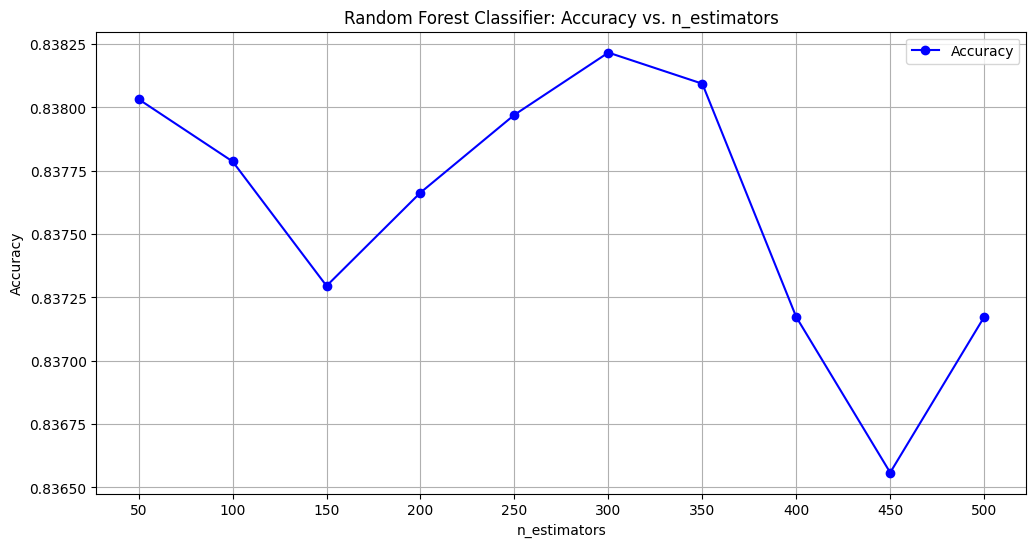

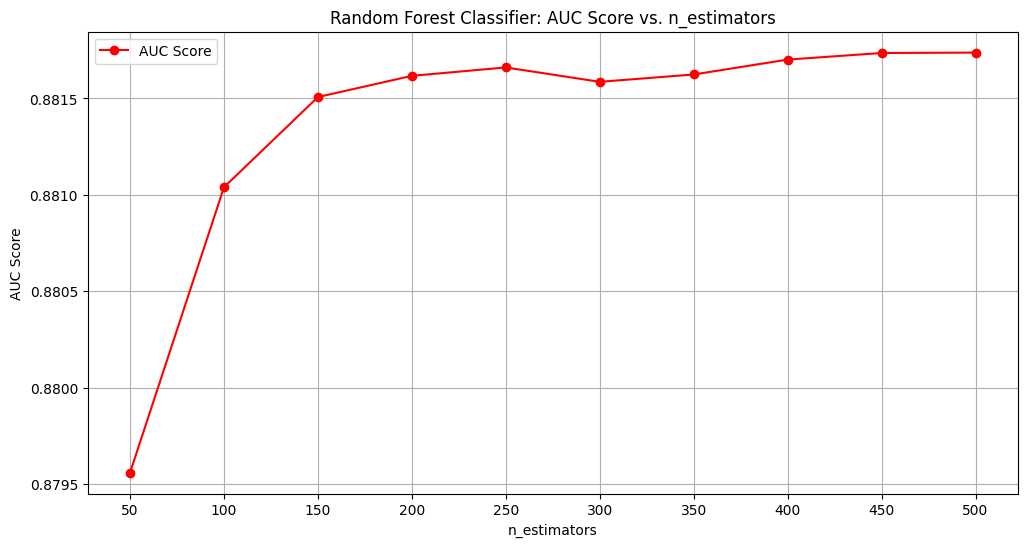

In [ ]:
import matplotlib.pyplot as plt

# Plotting Accuracy vs. n_estimators
plt.figure(figsize=(12, 6))
plt.plot(n_estimators_options, rf_accuracy_results, marker='o', linestyle='-', color='b', label='Accuracy')
plt.title('Random Forest Classifier: Accuracy vs. n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.grid(True)
plt.xticks(n_estimators_options)
plt.legend()
plt.show()

# Plotting AUC vs. n_estimators
plt.figure(figsize=(12, 6))
plt.plot(n_estimators_options, rf_auc_results, marker='o', linestyle='-', color='r', label='AUC Score')
plt.title('Random Forest Classifier: AUC Score vs. n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('AUC Score')
plt.grid(True)
plt.xticks(n_estimators_options)
plt.legend()
plt.show()

# Part 3


## Q1: Write your observations about the Classifier’s behavior with respect to the number of estimators

The accuracy is relatively stable sitting around 83%. The peak accuracy is at 150 estimators. Between 50 and 300 estimators the accuracy fluctuates, but over 300 estimators the accuracy tends to plateau. The AUC score consistently improves with increasing number of estimators. According to our model the number of estimators rises until 250 estimators, but after 300 estimators the model pleateaus. Our models show that after 300 estimators the processing is irrelevant having minimal changes.

## Q2: Is there an optimal value of the estimator within the given range?
According to our code and model the optimal value of estimators is 250. The accuracy is nearly the highest according to our model with one of the best AUC scores. With the minimal changes of values after 300 estimators we determine 250 to be the optimal value.

# Part 4

In [20]:
# AdaBoost

from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import roc_auc_score

# 1. Initialize lists for AdaBoost accuracy and AUC
ada_accuracy_results = []
ada_auc_results = []

# n_estimators_options is already defined in the previous cell
# preprocessor is already defined in the previous cell

# 3. Loop through each n_estimators value
for n_estimators in n_estimators_options:
    # 4. Create a machine learning Pipeline
    model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', AdaBoostClassifier(n_estimators=n_estimators, random_state=42))])

    # 5. Fit the model to training data
    model.fit(x_train, y_train)

    # 6. Make predictions on x_test
    y_pred = model.predict(x_test)

    # 7. Predict probabilities for the positive class on x_test
    y_pred_proba = model.predict_proba(x_test)[:, 1]

    # 8. Calculate accuracy_score and append to ada_accuracy_results
    accuracy = accuracy_score(y_test, y_pred)
    ada_accuracy_results.append(accuracy)

    # 9. Calculate roc_auc_score and append to ada_auc_results
    auc = roc_auc_score(y_test, y_pred_proba)
    ada_auc_results.append(auc)

# 10. Print both ada_accuracy_results and ada_auc_results
print("AdaBoost Accuracy Results:", ada_accuracy_results)
print("AdaBoost AUC Results:", ada_auc_results)

AdaBoost Accuracy Results: [0.8454026165468952, 0.8458325655672256, 0.8454640378355138, 0.8454026165468952, 0.8453411952582766, 0.845095510103802, 0.8447884036607088, 0.8447884036607088, 0.8447884036607088, 0.8447884036607088]
AdaBoost AUC Results: [np.float64(0.8964579725127083), np.float64(0.8974291380179534), np.float64(0.8973866184241257), np.float64(0.8973278834651577), np.float64(0.8973944176906602), np.float64(0.89735425042253), np.float64(0.8973755572659576), np.float64(0.8973753272607784), np.float64(0.8973790909818943), np.float64(0.8973785473332886)]


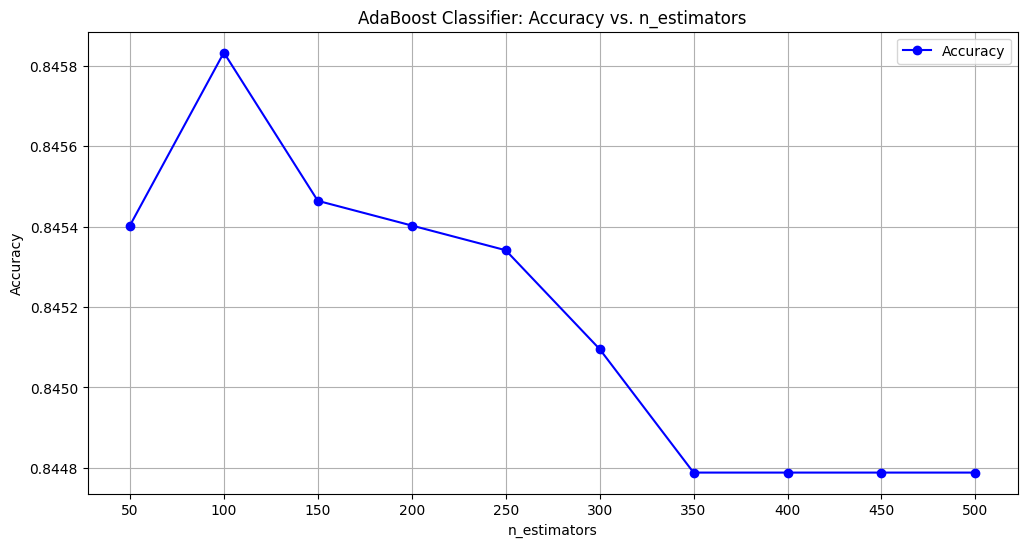

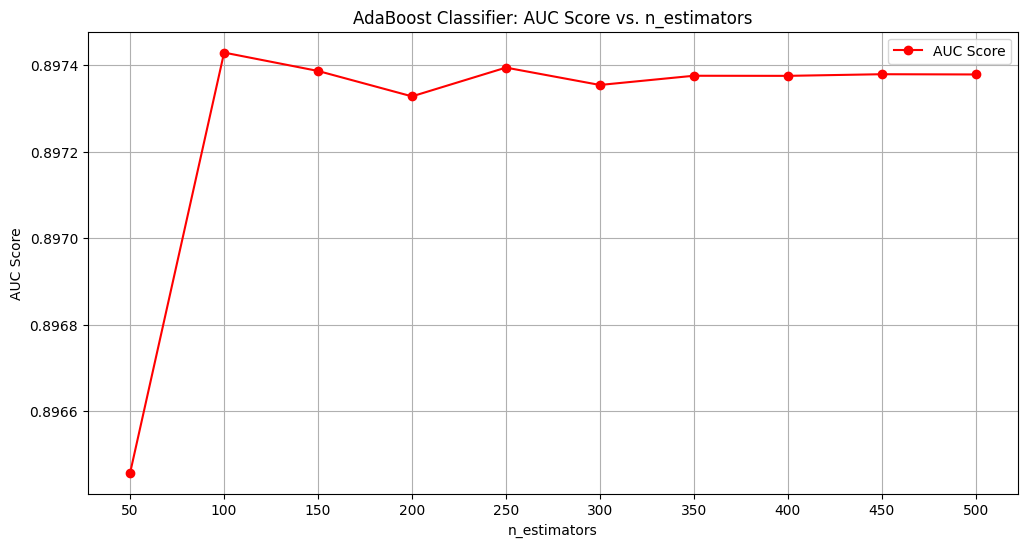

In [21]:
import matplotlib.pyplot as plt

# Plotting Accuracy vs. n_estimators for AdaBoost
plt.figure(figsize=(12, 6))
plt.plot(n_estimators_options, ada_accuracy_results, marker='o', linestyle='-', color='b', label='Accuracy')
plt.title('AdaBoost Classifier: Accuracy vs. n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.grid(True)
plt.xticks(n_estimators_options)
plt.legend()
plt.show()

# Plotting AUC vs. n_estimators for AdaBoost
plt.figure(figsize=(12, 6))
plt.plot(n_estimators_options, ada_auc_results, marker='o', linestyle='-', color='r', label='AUC Score')
plt.title('AdaBoost Classifier: AUC Score vs. n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('AUC Score')
plt.grid(True)
plt.xticks(n_estimators_options)
plt.legend()
plt.show()

In [22]:
# Gradient Boost

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import roc_auc_score

# 1. Initialize lists for Gradient Boosting accuracy and AUC
gbc_accuracy_results = []
gbc_auc_results = []

# n_estimators_options is already defined
# preprocessor is already defined

# 3. Loop through each n_estimators value
for n_estimators in n_estimators_options:
    # 4. Create a machine learning Pipeline
    model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', GradientBoostingClassifier(n_estimators=n_estimators, random_state=42))])

    # 5. Fit the model to training data
    model.fit(x_train, y_train)

    # 6. Make predictions on x_test
    y_pred = model.predict(x_test)

    # 7. Predict probabilities for the positive class on x_test
    y_pred_proba = model.predict_proba(x_test)[:, 1]

    # 8. Calculate accuracy_score and append to gbc_accuracy_results
    accuracy = accuracy_score(y_test, y_pred)
    gbc_accuracy_results.append(accuracy)

    # 9. Calculate roc_auc_score and append to gbc_auc_results
    auc = roc_auc_score(y_test, y_pred_proba)
    gbc_auc_results.append(auc)

# 10. Print both gbc_accuracy_results and gbc_auc_results
print("Gradient Boosting Accuracy Results:", gbc_accuracy_results)
print("Gradient Boosting AUC Results:", gbc_auc_results)

Gradient Boosting Accuracy Results: [0.8472452552054542, 0.8465696210306493, 0.8459554081444629, 0.8458939868558443, 0.8462625145875561, 0.8461396720103188, 0.8458325655672256, 0.8454026165468952, 0.8453411952582766, 0.8447269823720902]
Gradient Boosting AUC Results: [np.float64(0.8973956513548037), np.float64(0.8988557242329902), np.float64(0.8990284163035198), np.float64(0.8990456248728438), np.float64(0.8988901204620763), np.float64(0.8988598225070941), np.float64(0.898800836633385), np.float64(0.8986390175349676), np.float64(0.898690308689951), np.float64(0.8985171356995011)]


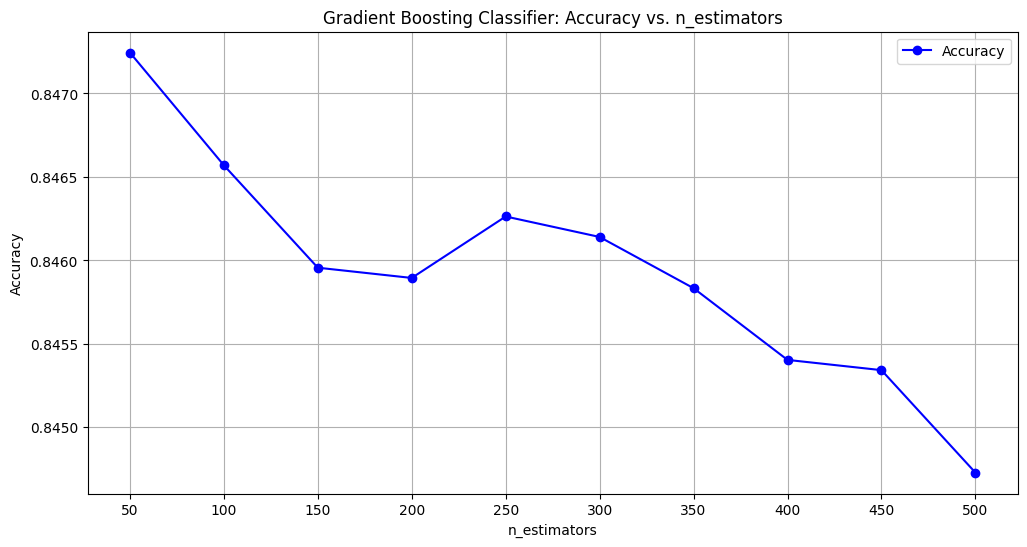

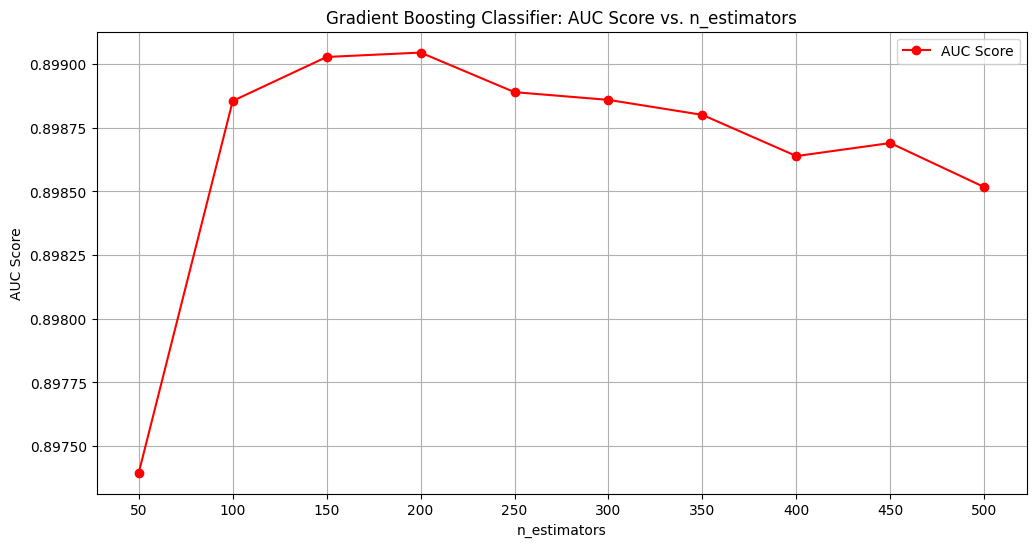

In [23]:
import matplotlib.pyplot as plt

# Plotting Accuracy vs. n_estimators for Gradient Boosting
plt.figure(figsize=(12, 6))
plt.plot(n_estimators_options, gbc_accuracy_results, marker='o', linestyle='-', color='b', label='Accuracy')
plt.title('Gradient Boosting Classifier: Accuracy vs. n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.grid(True)
plt.xticks(n_estimators_options)
plt.legend()
plt.show()

# Plotting AUC vs. n_estimators for Gradient Boosting
plt.figure(figsize=(12, 6))
plt.plot(n_estimators_options, gbc_auc_results, marker='o', linestyle='-', color='r', label='AUC Score')
plt.title('Gradient Boosting Classifier: AUC Score vs. n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('AUC Score')
plt.grid(True)
plt.xticks(n_estimators_options)
plt.legend()
plt.show()

In [24]:
# XGB

from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# 1. Initialize lists for XGBoost accuracy and AUC
xgb_accuracy_results = []
xgb_auc_results = []

# n_estimators_options is already defined
# preprocessor is already defined

# 3. Loop through each n_estimators value
for n_estimators in n_estimators_options:
    # 4. Create a machine learning Pipeline
    # It's good practice to set use_label_encoder=False and eval_metric for newer XGBoost versions
    model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', XGBClassifier(n_estimators=n_estimators, random_state=42, use_label_encoder=False, eval_metric='logloss'))])

    # 5. Fit the model to training data
    model.fit(x_train, y_train)

    # 6. Make predictions on x_test
    y_pred = model.predict(x_test)

    # 7. Predict probabilities for the positive class on x_test
    y_pred_proba = model.predict_proba(x_test)[:, 1]

    # 8. Calculate accuracy_score and append to xgb_accuracy_results
    accuracy = accuracy_score(y_test, y_pred)
    xgb_accuracy_results.append(accuracy)

    # 9. Calculate roc_auc_score and append to xgb_auc_results
    auc = roc_auc_score(y_test, y_pred_proba)
    xgb_auc_results.append(auc)

# 10. Print both xgb_accuracy_results and xgb_auc_results
print("XGBoost Accuracy Results:", xgb_accuracy_results)
print("XGBoost AUC Results:", xgb_auc_results)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:200: UserWarning: [03:29:28] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:200: UserWarning: [03:29:28] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:200: UserWarning: [03:29:28] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:200: UserWarning: [03:29:29] WARNING: /__w/xgboost/xgboost/src/learner.cc:782: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:

XGBoost Accuracy Results: [0.8442356120631411, 0.8440513481972852, 0.8429457650021498, 0.842577237270438, 0.8414716540753026, 0.8407345986118788, 0.8403046495915484, 0.8398747005712179, 0.8399975431484552, 0.8387691173760825]
XGBoost AUC Results: [np.float64(0.8963341983619032), np.float64(0.8940625417537812), np.float64(0.892592317283363), np.float64(0.8912238178308797), np.float64(0.8900153915284074), np.float64(0.8892729975383173), np.float64(0.8884991555673485), np.float64(0.8880795843011846), np.float64(0.8874208703772356), np.float64(0.8865841324445096)]


In [25]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score

# 1. Initialize lists for XGBoost accuracy and AUC
xgb_accuracy_results = []
xgb_auc_results = []

# n_estimators_options is already defined
# preprocessor is already defined

# 3. Loop through each n_estimators value
for n_estimators in n_estimators_options:
    # 4. Create a machine learning Pipeline
    # Removed use_label_encoder as it is deprecated
    model = Pipeline(steps=[('preprocessor', preprocessor),
                            ('classifier', XGBClassifier(n_estimators=n_estimators, random_state=42, eval_metric='logloss'))])

    # 5. Fit the model to training data
    model.fit(x_train, y_train)

    # 6. Make predictions on x_test
    y_pred = model.predict(x_test)

    # 7. Predict probabilities for the positive class on x_test
    y_pred_proba = model.predict_proba(x_test)[:, 1]

    # 8. Calculate accuracy_score and append to xgb_accuracy_results
    accuracy = accuracy_score(y_test, y_pred)
    xgb_accuracy_results.append(accuracy)

    # 9. Calculate roc_auc_score and append to xgb_auc_results
    auc = roc_auc_score(y_test, y_pred_proba)
    xgb_auc_results.append(auc)

# 10. Print both xgb_accuracy_results and xgb_auc_results
print("XGBoost Accuracy Results:", xgb_accuracy_results)
print("XGBoost AUC Results:", xgb_auc_results)

XGBoost Accuracy Results: [0.8442356120631411, 0.8440513481972852, 0.8429457650021498, 0.842577237270438, 0.8414716540753026, 0.8407345986118788, 0.8403046495915484, 0.8398747005712179, 0.8399975431484552, 0.8387691173760825]
XGBoost AUC Results: [np.float64(0.8963341983619032), np.float64(0.8940625417537812), np.float64(0.892592317283363), np.float64(0.8912238178308797), np.float64(0.8900153915284074), np.float64(0.8892729975383173), np.float64(0.8884991555673485), np.float64(0.8880795843011846), np.float64(0.8874208703772356), np.float64(0.8865841324445096)]


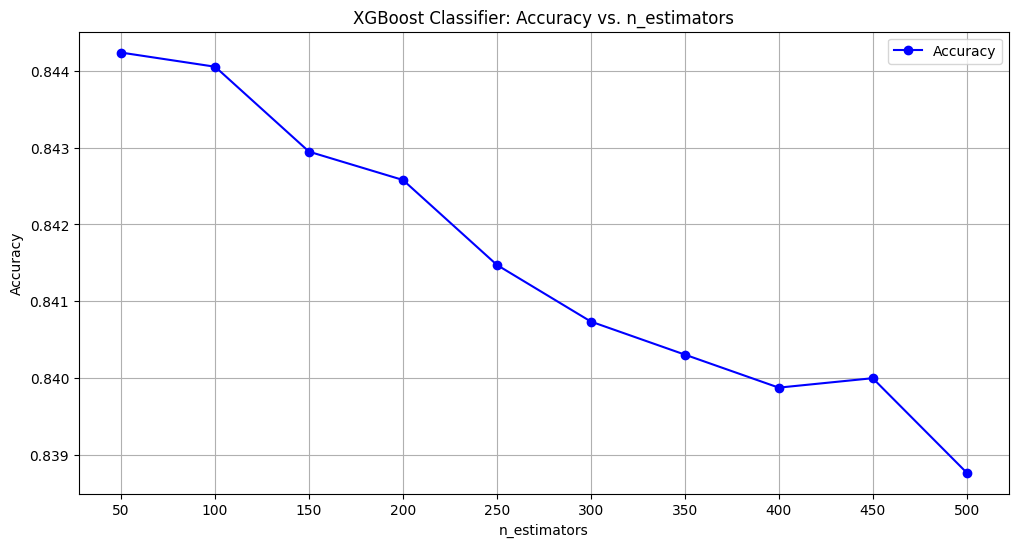

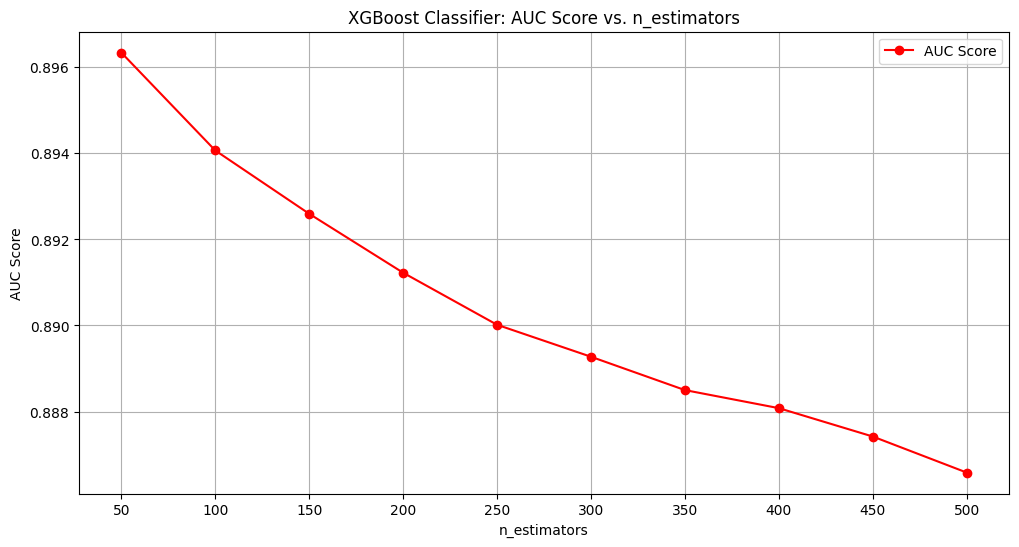

In [26]:
import matplotlib.pyplot as plt

# Plotting Accuracy vs. n_estimators for XGBoost
plt.figure(figsize=(12, 6))
plt.plot(n_estimators_options, xgb_accuracy_results, marker='o', linestyle='-', color='b', label='Accuracy')
plt.title('XGBoost Classifier: Accuracy vs. n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('Accuracy')
plt.grid(True)
plt.xticks(n_estimators_options)
plt.legend()
plt.show()

# Plotting AUC vs. n_estimators for XGBoost
plt.figure(figsize=(12, 6))
plt.plot(n_estimators_options, xgb_auc_results, marker='o', linestyle='-', color='r', label='AUC Score')
plt.title('XGBoost Classifier: AUC Score vs. n_estimators')
plt.xlabel('n_estimators')
plt.ylabel('AUC Score')
plt.grid(True)
plt.xticks(n_estimators_options)
plt.legend()
plt.show()

# Part 5

In [30]:
# --- Numbers-only comparison matrix: rows = {Accuracy, AUC}, cols = {Random Forest, AdaBoost, Gradient Boost, XGB} ---

import numpy as np
import pandas as pd

pretty_names = {
    'RandomForest':     'Random Forest',
    'AdaBoost':         'AdaBoost',
    'GradientBoosting': 'Gradient Boost',
    'XGBoost':          'XGB'
}

# Ensure each model key exists in RESULTS (may be empty if not run)
for key in ['RandomForest', 'AdaBoost', 'GradientBoosting', 'XGBoost']:
    RESULTS.setdefault(key, pd.DataFrame(columns=['n_estimators', 'accuracy', 'auc']))

def _best_value_only(df, metric):
    """Return best metric value (float) or NaN if unavailable."""
    if df.empty or metric not in df.columns or df[metric].isna().all():
        return np.nan
    row = df.loc[df[metric].idxmax()]
    return float(row[metric])

acc_row = {}
auc_row = {}

for internal, pretty in pretty_names.items():
    df_res = RESULTS[internal]
    best_acc = _best_value_only(df_res, 'accuracy')
    best_auc = _best_value_only(df_res, 'auc')

    # Numbers only, 4 decimals; blank if NaN (optional: keep NaN to see missing)
    acc_row[pretty] = "" if np.isnan(best_acc) else f"{best_acc:.4f}"
    auc_row[pretty] = "" if np.isnan(best_auc) else f"{best_auc:.4f}"

comparison_matrix = pd.DataFrame(
    [acc_row, auc_row],
    index=['Accuracy', 'AUC']
)[['Random Forest', 'AdaBoost', 'Gradient Boost', 'XGB']]

display(comparison_matrix)

,Random Forest,AdaBoost,Gradient Boost,XGB
Accuracy,0.8382,0.8458,0.8472,0.8442
AUC,0.8817,0.8974,0.8990,0.8963
